In [2]:
import pandas as pd
import numpy as np

# Preprocesamiento de los datos

In [2]:
########################################################################################    BBDD CHINA
X_train = pd.read_pickle("./Datasets/China/X_train_China_Augmented.pkl")
X_val = pd.read_pickle("./Datasets/China/X_val_China.pkl")
X_test = pd.read_pickle("./Datasets/China/X_test_China.pkl")

y_train = pd.read_pickle("./Datasets/China/y_train_China_Augmented.pkl")
y_val = pd.read_pickle("./Datasets/China/y_val_China.pkl")
y_test = pd.read_pickle("./Datasets/China/y_test_China.pkl")

fs = 1000

In [3]:
########################################################################################    BBDD COLOMBIA
X_train = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_train_Augmented_EMD.pkl"))
X_val = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_val.pkl"))
X_test = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_test.pkl"))

y_train = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_train_Augmented_EMD.pkl"))
y_val = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_val.pkl"))
y_test = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_test.pkl"))

fs = 100

In [4]:
from scipy.signal import butter, filtfilt

# Filtrado de paso bajo (ajustar el corte si es necesario)
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Convertir DataFrame a array numpy una vez filtradas las señales     
X_train = pd.DataFrame(butter_lowpass_filter(X_train, cutoff=5, fs=fs)).values
X_val = pd.DataFrame(butter_lowpass_filter(X_val, cutoff=5, fs=fs)).values
X_test = pd.DataFrame(butter_lowpass_filter(X_test, cutoff=5, fs=fs)).values

# Expandir dimensiones para incluir canales: (n_señales, n_muestras, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = y_train.astype(int).values.ravel()
y_val = y_val.astype(int).values.ravel()
y_test = y_test.astype(int).values.ravel()

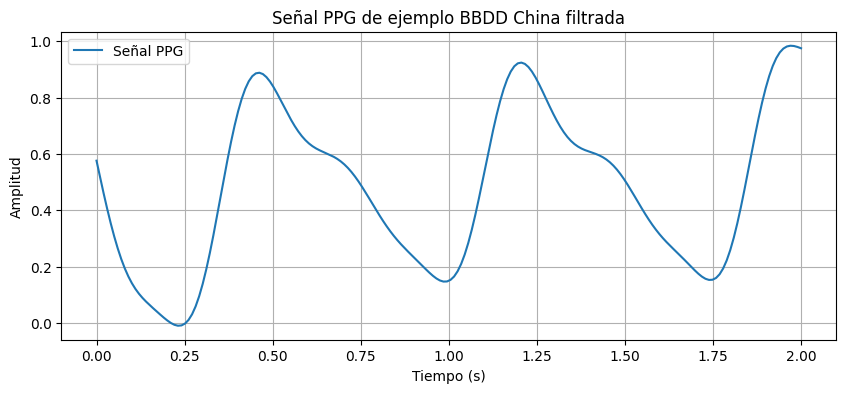

In [5]:
#Visualización de una señal del dataset
import matplotlib.pyplot as plt

# Seleccionar una señal de ejemplo
signal_example = X_train[0,:]  # Cambia el índice para visualizar otra señal

# Crear el eje de tiempo
sampling_rate = fs  # Frecuencia de muestreo (Hz), asumiendo 1 kHz para BBDD China
time = np.linspace(0, len(signal_example) / sampling_rate, len(signal_example))

# Visualizar la señal
plt.figure(figsize=(10, 4))
plt.plot(time, signal_example, label="Señal PPG")
plt.title("Señal PPG de ejemplo BBDD China filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()

In [9]:
from tensorflow.keras.callbacks import TensorBoard
import os

# Crear carpeta para guardar los logs de TensorBoard
log_dir = os.path.join("logs", "modelo_basico_cnn_bilstm")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Verificar la carpeta creada
print(f"Logs de TensorBoard se guardarán en: {log_dir}")

Logs de TensorBoard se guardarán en: logs\modelo_basico_cnn_bilstm


# Modelo CNN BiLSTM

In [10]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, TimeDistributed, Flatten, Dropout, Input

def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # Capa de entrada
    model.add(Input(shape=input_shape)) 
    
    # Capas Conv1D y BiLSTM 
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Flatten())

    model.add(Dense(1, activation='sigmoid'))

    return model

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import AUC

# 🔹 Creación del modelo
input_shape = (X_train.shape[1], 1)

model = create_cnn_lstm_model(input_shape)

# 🔹 Configuración del optimizador
optimizer = Adam(learning_rate=0.0001)  

# 🔹 Compilar modelo 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC()])

# 🔹 Calcular pesos de clases para entrenamiento balanceado
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# 🔹 Callbacks para optimización
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint("./Modelos/modelo_basico_cnn_bilstm/best_model.keras", monitor='val_loss', save_best_only=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 198, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 99, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 99, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12672)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          12,673 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,977 (308.50 KB)

 Trainable params: 78,977 (308.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 🔹 Entrenamiento con optimización mejorada
history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights, 
                    callbacks=[tensorboard_callback, reduce_lr, checkpoint])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.4925 - auc_1: 0.4910 - loss: 0.6950 - val_accuracy: 0.5994 - val_auc_1: 0.5048 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5775 - auc_1: 0.5961 - loss: 0.6897 - val_accuracy: 0.5865 - val_auc_1: 0.5064 - val_loss: 0.6807 - learning_rate: 1.0000e-04
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5875 - auc_1: 0.5811 - loss: 0.6852 - val_accuracy: 0.4936 - val_auc_1: 0.5123 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6085 - auc_1: 0.6338 - loss: 0.6741 - val_accuracy: 0.5000 - val_auc_1: 0.4642 - val_loss: 0.6984 - learning_rate: 1.0000e-04
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6237 - auc_1: 0.6535 - loss: 0.6643 - val_accuracy: 0.5064 - val_auc_1: 0.4310 - val_loss: 0.7054 - learning_rate: 5.0000e-05
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56m

# Resultados del entrenamiento

In [13]:
test_loss, test_accuracy, test_auc = model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5595 - auc_1: 0.3366 - loss: 0.7021    
Test Loss: 0.7234
Test Accuracy: 0.5128
Test AUC: 0.3888


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step 


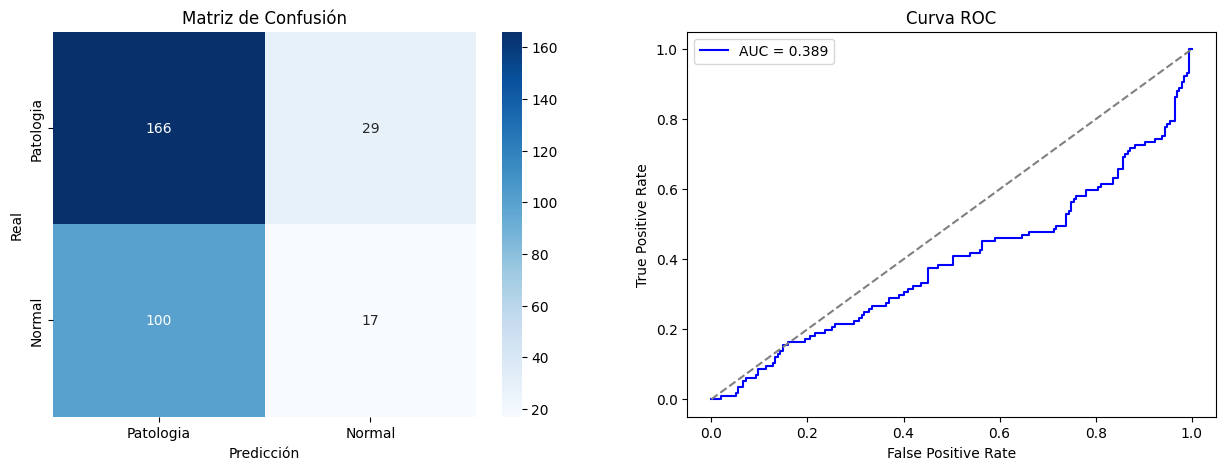


Umbral óptimo: 0.5528489351272583

Reporte de Clasificación:
               precision    recall  f1-score   support

   Patologia       0.62      0.85      0.72       195
      Normal       0.37      0.15      0.21       117

    accuracy                           0.59       312
   macro avg       0.50      0.50      0.46       312
weighted avg       0.53      0.59      0.53       312



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs_val = model.predict(X_val)  # Devuelve las probabilidades para cada clase


# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs_val)
roc_auc = auc(fpr, tpr)
# Calcular la diferencia entre TPR y FPR
optimal_idx = np.argmax(tpr - fpr)  # Índice del umbral óptimo
optimal_threshold = thresholds[optimal_idx]  # Umbral óptimo


threshold = optimal_threshold  # Umbral de decisión
y_pred = (y_pred_probs_val > threshold).astype(int)  # 1 para "Normal", 0 para "Anormal"
#y_pred = (y_pred_probs_test > 0.5).astype(int)  # Convierte a 0 o 1

# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred)



# Graficar la matriz de confusión
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Patologia", "Normal"], yticklabels=["Patologia", "Normal"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")


# Graficar la curva ROC
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

print(f"\nUmbral óptimo: {optimal_threshold}\n" )

# Reporte de clasificación
print("Reporte de Clasificación:\n", classification_report(y_val, y_pred, target_names=['Patologia', 'Normal']))



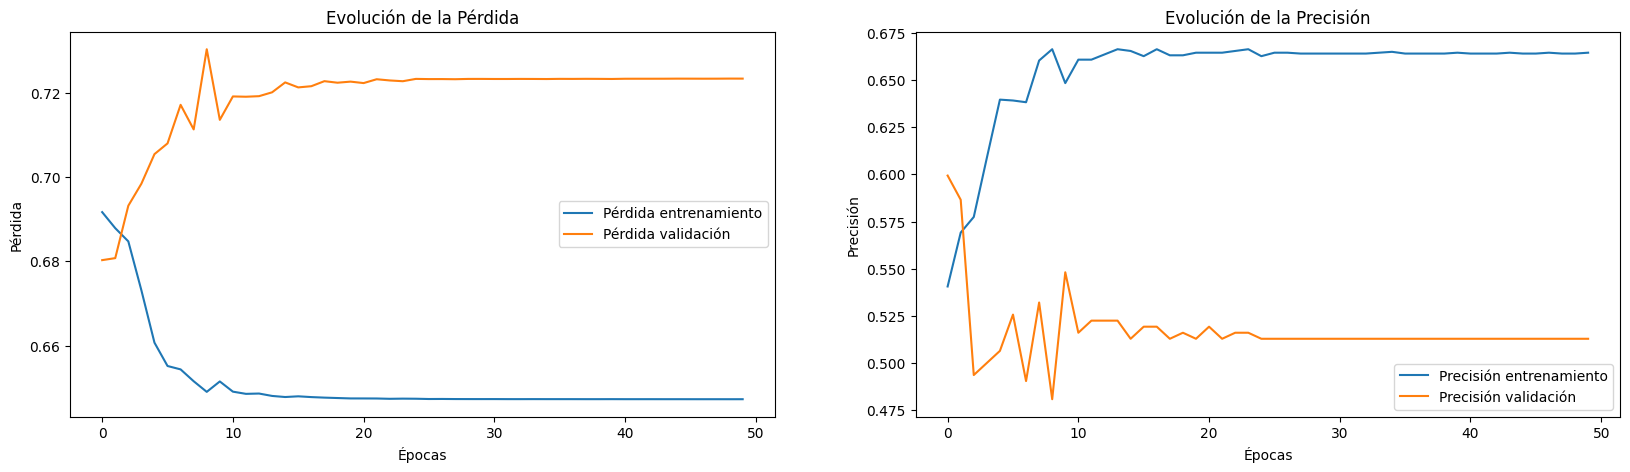

In [15]:
plt.figure(figsize=(20, 5))

# Gráfica de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Evolución de la Pérdida")

# Gráfica de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Evolución de la Precisión")

plt.show()

# Resultados fuera de muestra (test)

In [16]:
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3520 - auc_1: 0.3436 - loss: 0.7437    
Test Loss: 0.6954
Test Accuracy: 0.5026
Test AUC: 0.5281


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


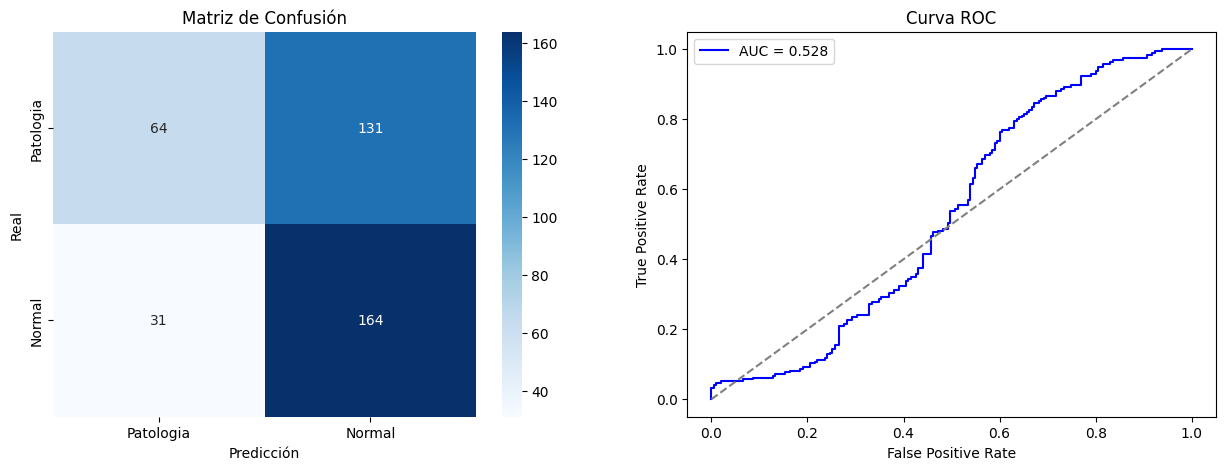


Umbral óptimo: 0.39729422330856323

Reporte de Clasificación:
               precision    recall  f1-score   support

   Patologia       0.67      0.33      0.44       195
      Normal       0.56      0.84      0.67       195

    accuracy                           0.58       390
   macro avg       0.61      0.58      0.56       390
weighted avg       0.61      0.58      0.56       390



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs_test = model.predict(X_test)  # Devuelve las probabilidades para cada clase


# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_test)
roc_auc = auc(fpr, tpr)
# Calcular la diferencia entre TPR y FPR
optimal_idx = np.argmax(tpr - fpr)  # Índice del umbral óptimo
optimal_threshold = thresholds[optimal_idx]  # Umbral óptimo


threshold = optimal_threshold  # Umbral de decisión
y_pred = (y_pred_probs_test > threshold).astype(int)  # 1 para "Normal", 0 para "Anormal"
#y_pred = (y_pred_probs_test > 0.5).astype(int)  # Convierte a 0 o 1

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)



# Graficar la matriz de confusión
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Patologia", "Normal"], yticklabels=["Patologia", "Normal"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")


# Graficar la curva ROC
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

print(f"\nUmbral óptimo: {optimal_threshold}\n" )

# Reporte de clasificación
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred, target_names=['Patologia', 'Normal']))



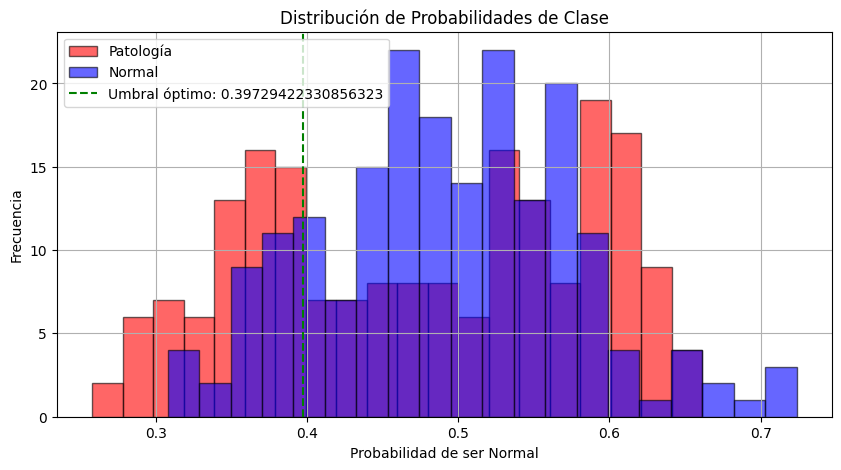

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Separar las probabilidades según la clase
proba_normal = y_pred_probs_test[y_test == 1]  # Probabilidades de la clase "Normal"
proba_patologia = y_pred_probs_test[y_test == 0]  # Probabilidades de la clase "Patologia"

# Crear histogramas
plt.figure(figsize=(10, 5))
plt.hist(proba_patologia, bins=20, alpha=0.6, label="Patología", color='red', edgecolor='black')
plt.hist(proba_normal, bins=20, alpha=0.6, label="Normal", color='blue', edgecolor='black')

# Personalización
plt.axvline(x=optimal_threshold, color='green', linestyle='dashed', label=f"Umbral óptimo: {optimal_threshold}")
plt.xlabel("Probabilidad de ser Normal")
plt.ylabel("Frecuencia")
plt.title("Distribución de Probabilidades de Clase")
plt.legend()
plt.grid(True)
plt.show()

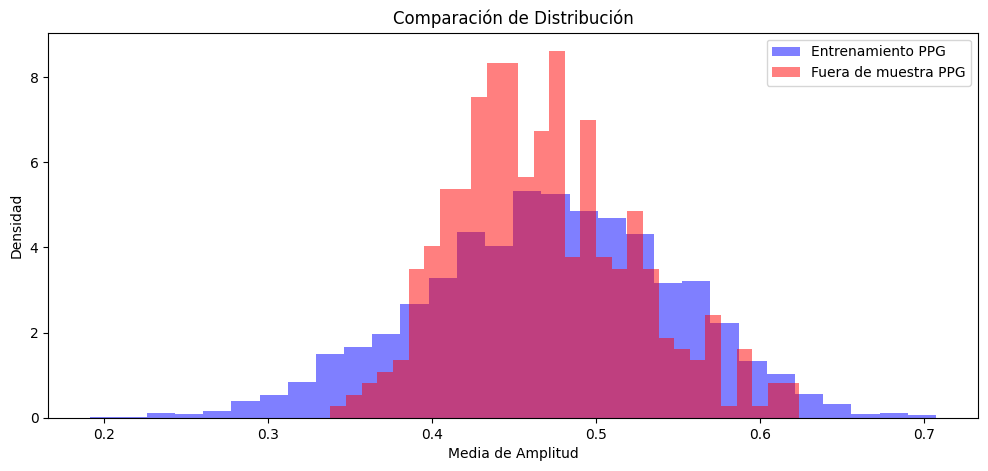

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(np.mean(X_train[:,:], axis=1), bins=30, alpha=0.5, label="Entrenamiento PPG", color='blue', density=True)
plt.hist(np.mean(X_test[:,:], axis=1), bins=30, alpha=0.5, label="Fuera de muestra PPG", color='red', density=True)
plt.xlabel("Media de Amplitud")
plt.ylabel("Densidad")
plt.legend()
plt.title("Comparación de Distribución")
plt.show()

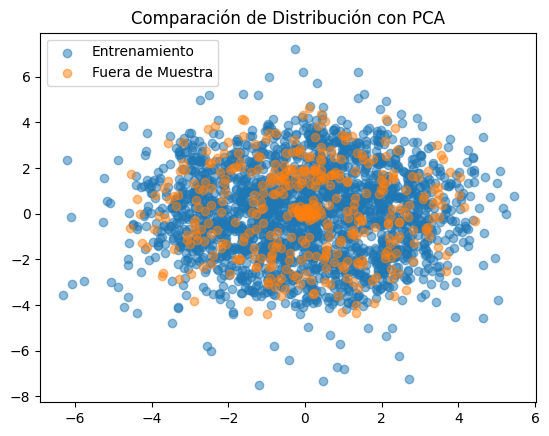

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train[:,:,0])
X_test_pca = pca.transform(X_test[:,:,0])

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label="Entrenamiento", alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label="Fuera de Muestra", alpha=0.5)
plt.legend()
plt.title("Comparación de Distribución con PCA")
plt.show()

# Guardar el modelo

In [19]:
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

plot_model(model, to_file='./Modelos/modelo_basico_cnn_bilstm/model_plot.png', show_shapes=True, show_layer_names=True)

visualkeras.layered_view(
    model, 
    font=font,
    legend=True, 
    spacing=50,  # Más espacio entre capas
    scale_xy=2,  # Escala horizontal/vertical
    scale_z=1    # Reducir la profundidad 3D para que sea más claro
).save('./Modelos/modelo_basico_cnn_bilstm/keras_3D.png')

visualkeras.layered_view(
    model, 
    font=font,
    legend=True, 
    spacing=40, 
    draw_volume=False  # Desactiva la vista en 3D
).save('./Modelos/modelo_basico_cnn_bilstm/keras_2D.png')

C:\Users\Fernando\tfm_env\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
